# Olist: BigQuery and Data Visualization

# DataSet: Olist 
- ___Data source___: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
- ___About Dataset___
Brazilian E-Commerce Public Dataset by Olist
Welcome! This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses.

# OLIST: Data visualization

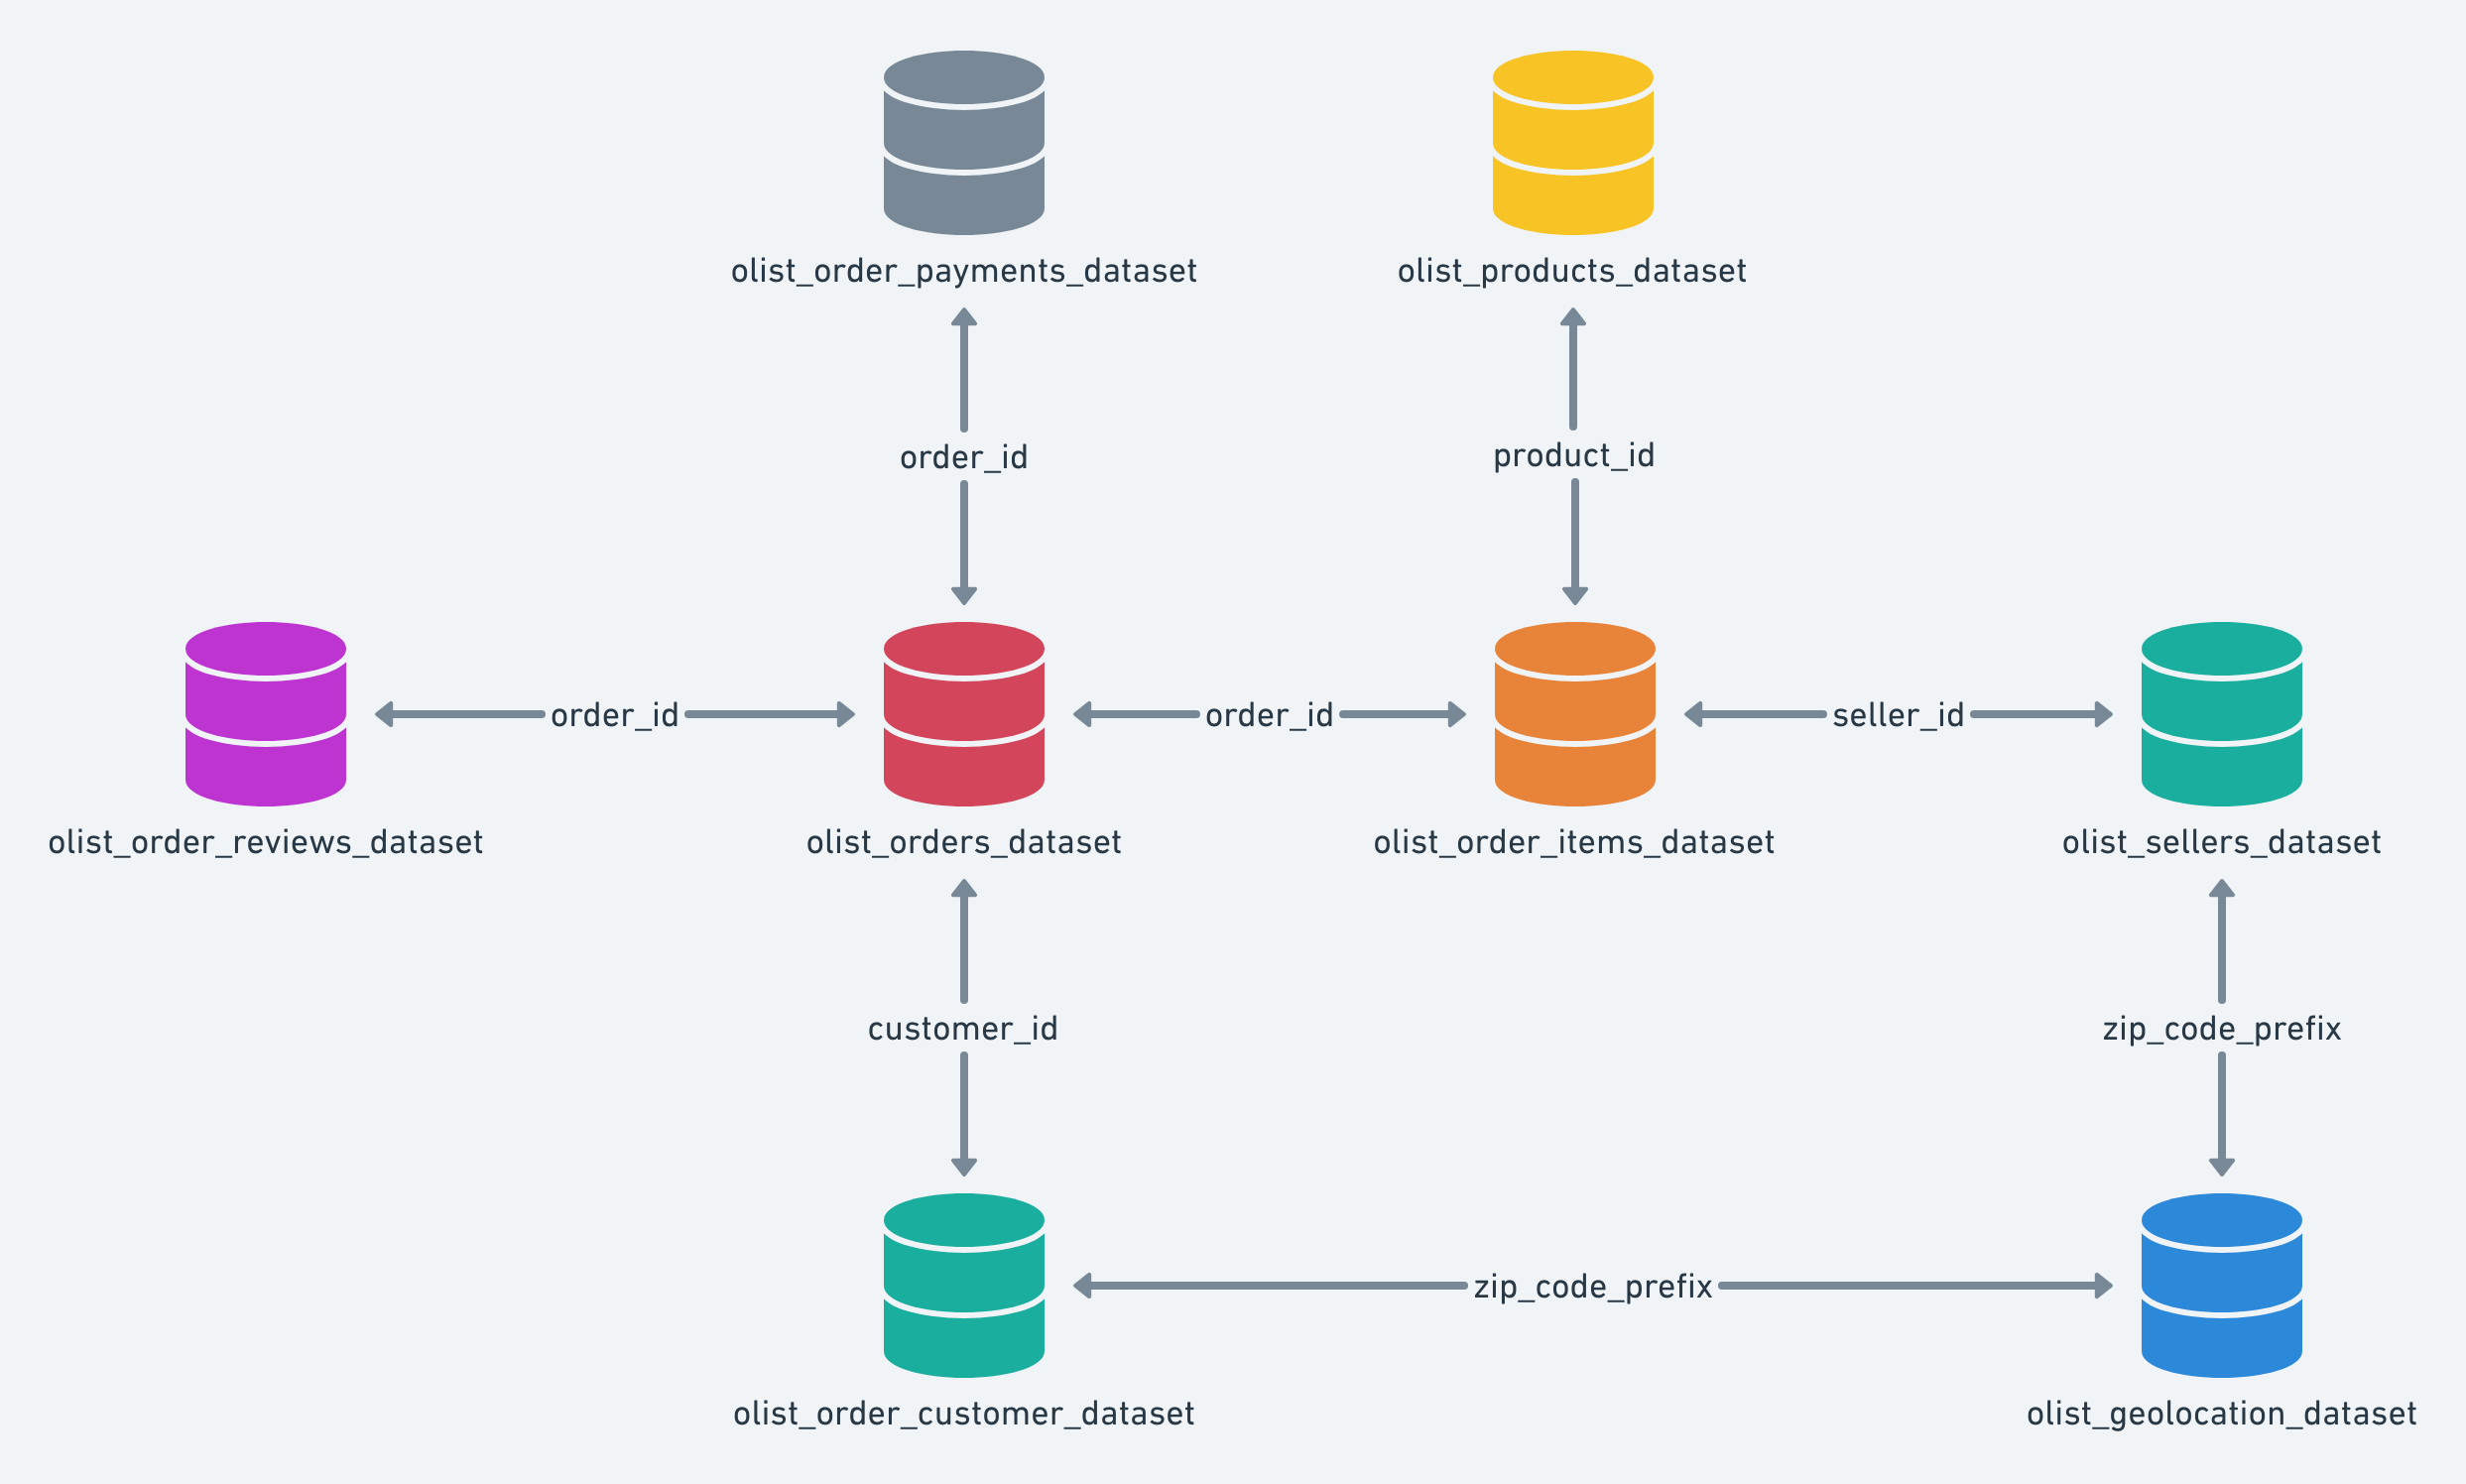

In [18]:
from IPython.display import Image
Image('https://i.imgur.com/HRhd2Y0.png')

## List of Visualization
- [Import all libraries and read data](#Import_all_libraries_and_read_data)
- [Data: data per year](#Data_per_year)
- [Percentage change of order number/revenue per month in 2017](#Percentage_change_of_order_number_revenue_per_month_in_2017)
- [Monthly Revenue in 2017: KDE plot](#Monthly_Revenue_in_2017:_KDE_plot)
- [Cancellation per month in 2017](#Cancellation_per_month_in_2017)
- [Popular product category in 2017](#Popular_product_category_in_2017)
- [2017 best monthly seller](#2017_best_monthly_seller)
- [2017 best selling state](#2017_best_selling_state)
- [Monthly order per state](#'Monthly_order_per_state')
- [Majority payment method in 2017](#Majority_payment_method_in_2017)
- [Most popular product category](#Most_popular_product_category)


### Import all libraries and read data<a id='#Import_all_libraries_and_read_data'></a>

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from google.cloud import bigquery
import pandas_gbq
import datetime as dt
# from sqlite3 import connect

# Construct a BigQuery client object.
client = bigquery.Client(project = 'robotic-branch-359514')

### Data per year<a id='Data_per_year'></a>

In OLIST dataset there are data for three years. Only year 2017 has complete data for 12 months. </br>
Therefore, the current project will focus on data analysis in 2017.

Downloading: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 83.52rows/s]


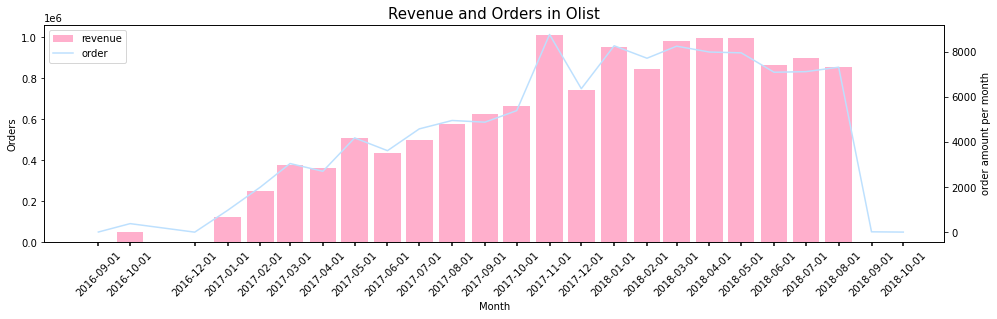

Some data in 2016 and 2018 are missing.
Therefore the current project will focus on year 2017


,date_time,year,month,order_per_month,revenue
0,2016-09-01 00:00:00+00:00,2016,9,7,267.36
1,2016-10-01 00:00:00+00:00,2016,10,379,49507.66
2,2016-12-01 00:00:00+00:00,2016,12,1,10.90
3,2017-01-01 00:00:00+00:00,2017,1,966,120312.87
4,2017-02-01 00:00:00+00:00,2017,2,1998,247303.02


In [38]:
########################################## SQL code ####################################################
sql = """
SELECT DATETIME_TRUNC(order_purchase_timestamp, MONTH) AS date_time,
        EXTRACT(YEAR FROM order_purchase_timestamp) AS year,
        EXTRACT(MONTH FROM order_purchase_timestamp) AS month,
        COUNT(*) AS order_per_month,
        SUM(price) AS revenue
        
        
FROM `nod-sql-copy.olist.orders`
LEFT JOIN `nod-sql-copy.olist.order_items` USING(order_id)
GROUP BY 1,2,3
ORDER BY 1,2,3
"""
df = pandas_gbq.read_gbq(sql)
########################################## Visualization ####################################################
fig, ax = plt.subplots(figsize = (20,4))
fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()

p1 = ax.bar(x = np.array(df['date_time']), height = np.array(df['revenue']), color = '#ffafcc', label ='revenue' , width=25)
p2, = twin1.plot(np.array(df['date_time']), np.array(df['order_per_month']), color = "#bde0fe", label="order")

try:
    plt.xticks(df.date_time, rotation = 45)
except ValueError:
    pass

ax.set_xticklabels(labels = df.date_time.dt.date, rotation = 45)

ax.set_xlabel("Month")
ax.set_ylabel("Orders")
twin1.set_ylabel('order amount per month')

ax.set_title('Order amount per month', fontsize = 15)
ax.legend(handles=[p1, p2])
#twin1.yaxis.label.set_color(p2.get_color())
tkw = dict(size=4, width=1.5)

ax.tick_params(axis='x', **tkw)
ax.set_title('Revenue and Orders in Olist', fontsize = 15)
plt.show()

########################################## Comment ####################################################
print('Some data in 2016 and 2018 are missing.')
print('Therefore the current project will focus on year 2017')
########################################## table from sql ####################################################
df.head()

### Percentage change of order number/revenue per month in 2017
<a id='Percentage_change_of_order number_revenue_per_month_in_2017'></a>

Downloading: 100%|██████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 118.93rows/s]


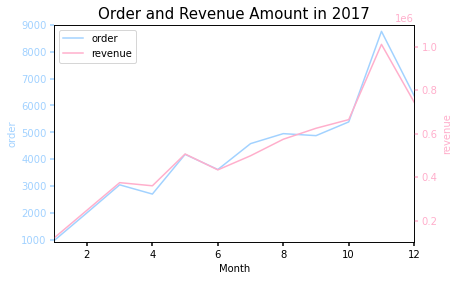

Finding:
- In 2017 order amount and revenue grow with time
- The ordering peak is in November. It might be the promotion for Black Friday
- Before Christmas (December) the ordering amount is the second peak in 2017


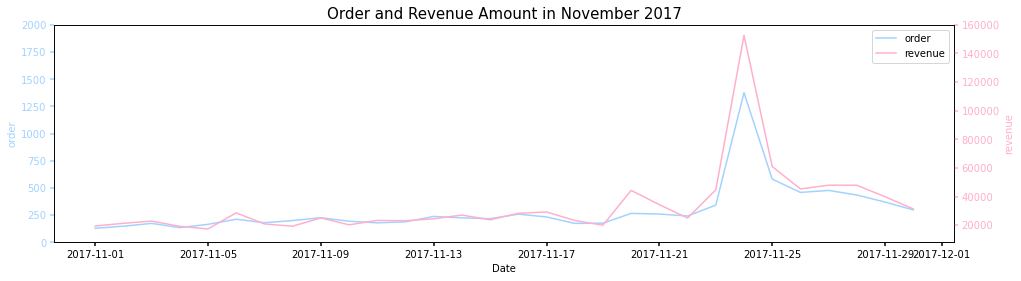

The order And revenue peak was caused by Black Friday (2017/11/24)


,month_2017,order_amount,revenue,pct_change_,pct_month_rev
0,1,966,120312.87,NaN,NaN
1,2,1998,247303.02,1.07,1.06
2,3,3041,374344.30,0.52,0.51
3,4,2697,359927.23,-0.11,-0.04
4,5,4176,506071.14,0.55,0.41
5,6,3611,433038.60,-0.14,-0.14
6,7,4576,498031.48,0.27,0.15
7,8,4948,573971.68,0.08,0.15
8,9,4873,624401.69,-0.02,0.09
9,10,5385,664219.43,0.11,0.06


In [56]:
########################################## SQL code ####################################################
####### SQL1

sql1 = """
WITH pct_change AS
  -- get the order number in 2017
  (SELECT 
        DATETIME_TRUNC(order_purchase_timestamp, MONTH) AS date_time,
        COUNT(*) AS order_amount,
        ROUND(SUM(price), 2) AS revenue
        --LAG(COUNT(*))OVER(ORDER BY DATETIME_TRUNC(order_purchase_timestamp, MONTH)) AS last_month, 
    FROM `nod-sql-copy.olist.orders`
    LEFT JOIN `nod-sql-copy.olist.order_items` AS oi USING(order_id)
    WHERE EXTRACT(YEAR FROM order_purchase_timestamp) = 2017
    GROUP BY 1
    ORDER BY 1)
-- calculate the average of monthly change
SELECT EXTRACT(MONTH FROM date_time) AS month_2017,
        order_amount, 
        revenue,
        -- LAG(order_amount)OVER(ORDER BY(date_time)) AS last_month,
        ROUND((order_amount -  LAG(order_amount)OVER(ORDER BY(date_time)))/ LAG(order_amount)OVER(ORDER BY(date_time)), 2) AS pct_change_,
        --LAG(revenue)OVER(ORDER BY month_ ) AS last_month,
  ROUND((revenue - LAG(revenue)OVER(ORDER BY date_time ))/LAG(revenue)OVER(ORDER BY date_time ), 2) AS pct_month_rev
  --ROUND(AVG(pct_change_2017), 2) AS avg_2017_month_pct
  FROM pct_change
  ORDER BY date_time"""

monthly_order_revenue = pandas_gbq.read_gbq(sql1)

####### SQL2
sql2 = """
SELECT 
        DATETIME_TRUNC(order_purchase_timestamp, DAY) AS date_time,
        COUNT(*) AS order_amount,
        ROUND(SUM(price), 2) AS revenue
        --LAG(COUNT(*))OVER(ORDER BY DATETIME_TRUNC(order_purchase_timestamp, MONTH)) AS last_month, 
    FROM `nod-sql-copy.olist.orders`
    LEFT JOIN `nod-sql-copy.olist.order_items` AS oi USING(order_id)
    WHERE EXTRACT(YEAR FROM order_purchase_timestamp) = 2017
       AND EXTRACT(MONTH FROM order_purchase_timestamp) IN (11)
    GROUP BY 1
    ORDER BY 1
"""
monthly_order_revenue_nov_dec = pandas_gbq.read_gbq(sql2)
########################################## Visualization ####################################################
####### CHART 1
fig, ax = plt.subplots(figsize = (8,4))
fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()
#twin2.spines.right.set_position(("axes", 1.2))

p1, = ax.plot(np.array(monthly_order_revenue['month_2017']), np.array(monthly_order_revenue['order_amount']), color = "#a2d2ff", label="order")
p2, = twin1.plot(np.array(monthly_order_revenue['month_2017']), np.array(monthly_order_revenue['revenue']) , "#ffafcc", label="revenue")


ax.set_xlim(1,12)
ax.set_ylim(900, 9000)
twin1.set_ylim(100000, 1100000)

ax.set_xlabel("Month")
ax.set_ylabel("order")
twin1.set_ylabel("revenue")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)
ax.legend(handles=[p1, p2])
ax.set_title('Order and Revenue Amount in 2017', fontsize = 15)

plt.show()

########################################## Comment ####################################################
print('Finding:')
print('- In 2017 order amount and revenue grow with time')
print('- The ordering peak is in November. It might be the promotion for Black Friday')
print('- Before Christmas (December) the ordering amount is the second peak in 2017')
####### CHART 2
fig, ax = plt.subplots(figsize = (20,4))
fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()

p1, = ax.plot(np.array(monthly_order_revenue_nov_dec['date_time']), np.array(monthly_order_revenue_nov_dec['order_amount']), color = "#a2d2ff", label="order")
p2, = twin1.plot(np.array(monthly_order_revenue_nov_dec['date_time']), np.array(monthly_order_revenue_nov_dec['revenue']) , "#ffafcc", label="revenue")

ax.set_ylim(0, 2000)
twin1.set_ylim(8000, 160000)

ax.set_xlabel("Date")
ax.set_ylabel("order")
twin1.set_ylabel("revenue")

ticks_loc = monthly_order_revenue_nov_dec['date_time'].dt.date
ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())


tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)

ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2])
ax.set_title('Order and Revenue Amount in November 2017', fontsize = 15)

plt.show()
########################################## Comment ####################################################
print('The order And revenue peak was caused by Black Friday (2017/11/24)')

########################################## table from sql ####################################################
monthly_order_revenue

In [24]:
# table form SQL2
monthly_order_revenue_nov_dec.head()

,date_time,order_amount,revenue
0,2017-11-01 00:00:00+00:00,129,19383.61
1,2017-11-02 00:00:00+00:00,148,21263.73
2,2017-11-03 00:00:00+00:00,174,22844.05
3,2017-11-04 00:00:00+00:00,135,19169.07
4,2017-11-05 00:00:00+00:00,165,17327.44


### Monthly Revenue in 2017: KDE plot<a id='Monthly_Revenue_in_2017:_KDE_plot'></a>

Downloading: 100%|██████████████████████████████████████████████████████████| 50864/50864 [00:03<00:00, 15637.28rows/s]


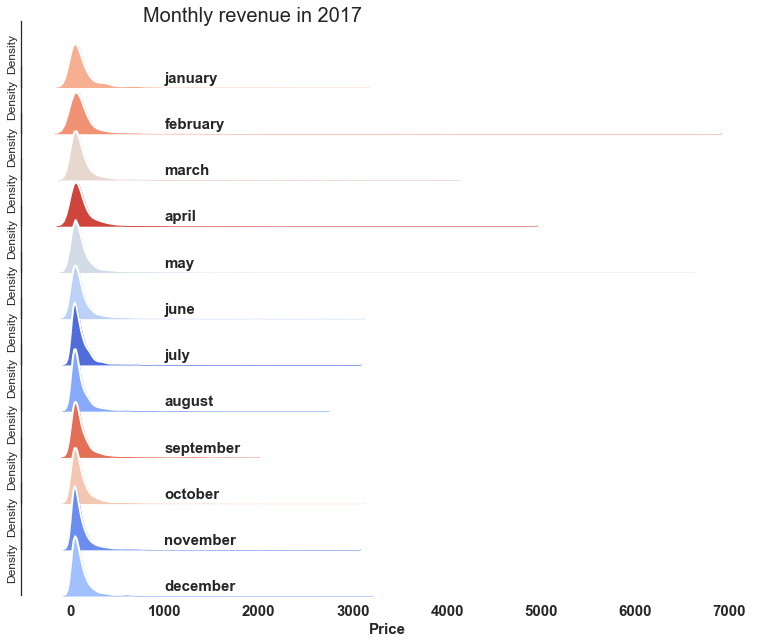

,order_purchase_timestamp,price,month,month_name,month_price_mean
0,2017-05-13 21:23:34+00:00,89.99,5,May,122.357626
1,2017-05-15 15:24:31+00:00,56.00,5,May,122.357626
2,2017-05-03 10:21:46+00:00,16.50,5,May,122.357626
3,2017-05-15 23:30:03+00:00,14.99,5,May,122.357626
4,2017-05-15 21:33:28+00:00,21.99,5,May,122.357626


In [45]:
#######################################################SQL CODE######################################################
##
sql = """
    WITH table AS 
    (SELECT 
        order_purchase_timestamp, 
        price,
        EXTRACT(MONTH FROM order_purchase_timestamp) AS month,
        
        CASE 
            WHEN EXTRACT(MONTH FROM order_purchase_timestamp) = 1 THEN 'Janurary'
            WHEN EXTRACT(MONTH FROM order_purchase_timestamp) = 2 THEN 'Ferbrary'
            WHEN EXTRACT(MONTH FROM order_purchase_timestamp) = 3 THEN 'March'
            WHEN EXTRACT(MONTH FROM order_purchase_timestamp) = 4 THEN 'April'
            WHEN EXTRACT(MONTH FROM order_purchase_timestamp) = 5 THEN 'May'
            WHEN EXTRACT(MONTH FROM order_purchase_timestamp) = 6 THEN 'June'
            WHEN EXTRACT(MONTH FROM order_purchase_timestamp) = 7 THEN 'July'
            WHEN EXTRACT(MONTH FROM order_purchase_timestamp) = 8 THEN 'August'
            WHEN EXTRACT(MONTH FROM order_purchase_timestamp) = 9 THEN 'September'
            WHEN EXTRACT(MONTH FROM order_purchase_timestamp) = 10 THEN 'October'
            WHEN EXTRACT(MONTH FROM order_purchase_timestamp) = 11 THEN 'November'
            WHEN EXTRACT(MONTH FROM order_purchase_timestamp) = 12 THEN 'December'
            ELSE 'problem' END
            AS month_name
            
    FROM `nod-sql-copy.olist.orders`
    LEFT JOIN `nod-sql-copy.olist.order_items` AS oi USING(order_id)
    WHERE EXTRACT(YEAR FROM order_purchase_timestamp) = 2017 AND price IS NOT NULL)
    
    SELECT *,
            AVG(price)OVER(PARTITION BY month_name) AS month_price_mean
    FROM table
    
"""
df = pandas_gbq.read_gbq(sql)
########################################################PLOT######################################################
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

month_dict = {1: 'january',   2: 'february', 3: 'march',    4: 'april',
              5: 'may',       6: 'june',     7: 'july',     8: 'august',
              9: 'september', 10: 'october', 11: 'november',12: 'december'}
# we generate a color palette with Seaborn.color_palette()
pal = sns.color_palette(palette='coolwarm', n_colors=12)

# in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
#g = sns.FacetGrid(df, row='month_name', hue='month_price_mean', aspect=15, height=0.75, palette=pal)
g = sns.FacetGrid(df, row='month', hue= 'month_price_mean'    ,aspect=15, height=0.75, palette=pal)

# then we add the densities kdeplots for each month
g.map(sns.kdeplot, 'price',
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)

# here we add a white line that represents the contour of each kdeplot
g.map(sns.kdeplot, 'price', 
      bw_adjust=1, clip_on=False, 
      color="w", lw=2)

# here we add a horizontal line for each plot
"""g.map(plt.axhline, y=-0.000009,
      lw=2, clip_on=False)"""

# we loop over the FacetGrid figure axes (g.axes.flat) and add the month as text with the right color
# notice how ax.lines[-1].get_color() enables you to access the last line's color in each matplotlib.Axes
for i, ax in enumerate(g.axes.flat):
    """ax.text(1000,0.0005, month_dict[i+1],
            fontweight='bold', fontsize=15,
            color=ax.lines[-1].get_color())"""
    
    ax.text(1000,0.0005, month_dict[i+1],
            fontweight='bold', fontsize=15)
    
# we use matplotlib.Figure.subplots_adjust() function to get the subplots to overlap
g.fig.subplots_adjust(hspace=-0.3)

# eventually we remove axes titles, yticks and spines
g.set_titles("")
g.set(yticks=[], yticklabels=[])
ax.set_yticks([])
g.despine(bottom=True, left=False)

plt.setp(ax.get_xticklabels(), fontsize=15, fontweight='bold')
plt.xlabel('Price', fontweight='bold', fontsize=15)
g.fig.suptitle('Monthly revenue in 2017',
               ha='right',
               fontsize=20,
               fontweight=20)


plt.show()
########################################################SQL table######################################################

df.head()

### Cancellation per month in 2017 <a id='Cancellation_per_month_in_2017'></a>

Downloading: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 43.95rows/s]


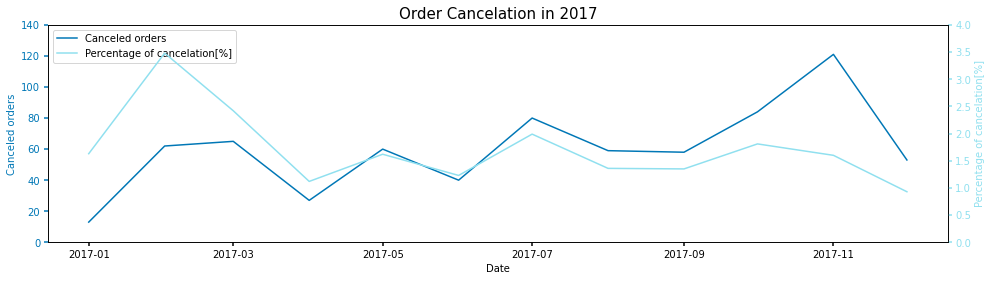

Finding:
- In Feburary percentage of cancelation is relatively heigh.
- In November the amount of canceled order is heigh but the total order is also heigh.
  Therefore, the percentage of cancelation is not that heigh


,month_,all_,cancell_unknown,pct_cancel
0,2017-01-01 00:00:00+00:00,800,13,1.63
1,2017-02-01 00:00:00+00:00,1780,62,3.48
2,2017-03-01 00:00:00+00:00,2682,65,2.42
3,2017-04-01 00:00:00+00:00,2404,27,1.12
4,2017-05-01 00:00:00+00:00,3700,60,1.62
5,2017-06-01 00:00:00+00:00,3245,40,1.23
6,2017-07-01 00:00:00+00:00,4026,80,1.99
7,2017-08-01 00:00:00+00:00,4331,59,1.36
8,2017-09-01 00:00:00+00:00,4285,58,1.35
9,2017-10-01 00:00:00+00:00,4631,84,1.81


In [3]:
########################################## SQL code ####################################################
sql = """
WITH table_1 AS 
    (SELECT DATE_TRUNC(order_purchase_timestamp, MONTH) AS month_, 
      COUNT(*) AS all_
      FROM `nod-sql-copy.olist.orders`
      WHERE  EXTRACT(YEAR FROM order_purchase_timestamp) = 2017
      GROUP BY 1
      ORDER BY 1),

  table_2 AS
      (SELECT DATE_TRUNC(order_purchase_timestamp, MONTH) AS month_, 
          COUNT(*) AS cancell_unknown
      FROM `nod-sql-copy.olist.orders`  
      WHERE order_status IN ('canceled', 'unavailable')
        AND EXTRACT(YEAR FROM order_purchase_timestamp) = 2017
      GROUP BY 1
      ORDER BY 1)
      
SELECT *, ROUND(cancell_unknown/all_*100, 2) AS pct_cancel
FROM table_1 AS a
JOIN table_2 AS b USING(month_) 
ORDER BY month_
"""
df = pandas_gbq.read_gbq(sql)
########################################## Visualization ####################################################
fig, ax = plt.subplots(figsize = (20,4))
fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()

p1, = ax.plot(np.array(df['month_']), np.array(df['cancell_unknown']), color = "#0077b6", label="Canceled orders")
p2, = twin1.plot(np.array(df['month_']), np.array(df['pct_cancel']) , "#90e0ef", label="Percentage of cancelation[%]")

ax.set_ylim(0, 140)
twin1.set_ylim(0, 4)

ax.set_xlabel("Date")
ax.set_ylabel("Canceled orders")
twin1.set_ylabel("Percentage of cancelation[%]")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)

ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2])
ax.set_title('Order Cancelation in 2017', fontsize = 15)

plt.show()
########################################## Comment ####################################################
print('Finding:')
print('- In Feburary percentage of cancelation is relatively heigh.')
print('- In November the amount of canceled order is heigh but the total order is also heigh.')
print('  Therefore, the percentage of cancelation is not that heigh')

########################################## table from sql ####################################################
df

### Popular product category in 2017 <a id='Popular_product_category_in_2017'></a>

In [18]:
sql = """
WITH table AS
    (SELECT *
    FROM `nod-sql-copy.olist.order_items`
    LEFT JOIN `nod-sql-copy.olist.orders` USING(order_id)
    LEFT JOIN `nod-sql-copy.olist.products` USING(product_id)
    ),

monthly_report AS
    (SELECT DATE_TRUNC(order_purchase_timestamp, MONTH) AS month_,
          product_category_name, 
          COUNT(*) AS total_order,
          ROUND(SUM(price)) AS total_revenue,
    FROM table
    WHERE EXTRACT(YEAR FROM order_purchase_timestamp) = 2017 
    GROUP BY 1, product_category_name
    ORDER BY 1,4 DESC),


monthly_report_2 AS 
    (SELECT month_, product_category_name,
        total_order, 
        SUM(total_order)OVER(PARTITION BY month_ ) AS total_order_month,
        total_revenue,
        SUM(total_revenue)OVER(PARTITION BY month_ ) AS total_rev_month
    FROM monthly_report)


SELECT month_, product_category_name, total_order,
      ROUND(total_order/total_order_month, 2) AS pct_tot_order,
      total_revenue,
      ROUND(total_revenue/total_rev_month,2) AS pct_tot_rev
FROM monthly_report_2
ORDER BY 1, total_revenue DESC"""




pandas_gbq.read_gbq(sql)

Downloading: 100%|███████████████████████████████████████████████████████████████| 715/715 [00:00<00:00, 2437.28rows/s]


,month_,product_category_name,total_order,pct_tot_order,total_revenue,pct_tot_rev
0,2017-01-01 00:00:00+00:00,moveis_decoracao,182,0.19,13521.0,0.11
1,2017-01-01 00:00:00+00:00,beleza_saude,85,0.09,12561.0,0.10
2,2017-01-01 00:00:00+00:00,esporte_lazer,80,0.08,9718.0,0.08
3,2017-01-01 00:00:00+00:00,ferramentas_jardim,58,0.06,8153.0,0.07
4,2017-01-01 00:00:00+00:00,relogios_presentes,11,0.01,8087.0,0.07
...,...,...,...,...,...,...
710,2017-12-01 00:00:00+00:00,artes,3,0.00,115.0,0.00
711,2017-12-01 00:00:00+00:00,flores,2,0.00,83.0,0.00
712,2017-12-01 00:00:00+00:00,fraldas_higiene,2,0.00,76.0,0.00
713,2017-12-01 00:00:00+00:00,cds_dvds_musicais,1,0.00,65.0,0.00


### 2017 best monthly  seller <a id='2017_best_monthly_seller'></a>

Downloading: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 37.78rows/s]
C:\Users\ACER\AppData\Local\Temp/ipykernel_9384/3436140978.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = x)


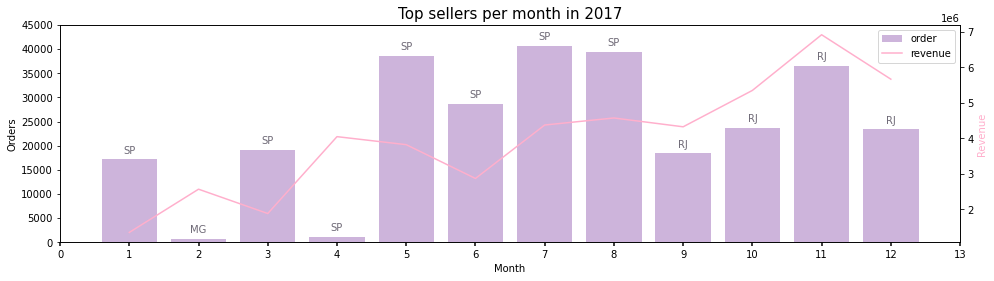

The chart show the top seller per month in 2017
The ids of top sellers show in the table
The chart shows the total orders of the top seller in each month (left axis)
and the total revenue of the top seller in each month (right axis)
Texts above bars are the state where sellers located


,month_,seller_id,state,tot_order_per_seller,tot_rev_per_seller,rank
0,1,cca3071e3e9bb7d12640c9fbe2301306,SP,17160,1.351236e+06,1
1,2,585175ec331ea177fa47199e39a6170a,MG,724,2.569476e+06,1
2,3,4a3ca9315b744ce9f8e9374361493884,SP,19162,1.883682e+06,1
3,4,59417c56835dd8e2e72f91f809cd4092,SP,1085,4.050522e+06,1
4,5,4a3ca9315b744ce9f8e9374361493884,SP,38610,3.824506e+06,1
5,6,4a3ca9315b744ce9f8e9374361493884,SP,28600,2.872069e+06,1
6,7,4a3ca9315b744ce9f8e9374361493884,SP,40612,4.378428e+06,1
7,8,4a3ca9315b744ce9f8e9374361493884,SP,39468,4.576744e+06,1
8,9,46dc3b2cc0980fb8ec44634e21d2718e,RJ,18408,4.328198e+06,1
9,10,46dc3b2cc0980fb8ec44634e21d2718e,RJ,23712,5.353670e+06,1


In [96]:
##################################################SQL CODE#######################################################
sql = """
WITH all_table AS
  (SELECT *
  FROM `nod-sql-copy.olist.orders`
  LEFT JOIN `nod-sql-copy.olist.order_items` USING(order_id)
  LEFT JOIN `nod-sql-copy.olist.sellers` AS s USING(seller_id)
  LEFT JOIN `nod-sql-copy.olist.geolocation` AS g ON s.seller_zip_code_prefix = g.geolocation_zip_code_prefix
  
   WHERE EXTRACT(YEAR FROM order_purchase_timestamp) = 2017),

table2 AS
    (SELECT EXTRACT(MONTH FROM order_purchase_timestamp) AS month_,
            seller_id, 
            ANY_VALUE(seller_state) AS state,

            COUNT(*) AS tot_order_per_seller,
            SUM(price) AS tot_rev_per_seller,

    FROM all_table
    GROUP BY 1,seller_id
    ORDER BY 1,tot_rev_per_seller DESC)
    
SELECT *,
        RANK()OVER(PARTITION BY month_ ORDER BY tot_rev_per_seller DESC) AS rank
FROM table2
ORDER BY rank, month_
LIMIT 12

;"""


df = pandas_gbq.read_gbq(sql)
##################################################VISUALIZATION#######################################################
fig, ax = plt.subplots(figsize = (20,4))
fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()

p1 = ax.bar(x = np.array(df['month_']), height = np.array(df['tot_order_per_seller']), color = '#cdb4db', label ='order' )
p2, = twin1.plot(np.array(df['month_']), np.array(df['tot_rev_per_seller']), color = "#ffafcc", label="revenue")

ax.set_xlabel("Month")
ax.set_ylabel("Orders")
twin1.set_ylabel("Revenue", color = '#cdb4db')

ax.legend(handles=[p1, p2])
twin1.yaxis.label.set_color(p2.get_color())
tkw = dict(size=4, width=1.5)

ax.set_xlim(0,13)
ax.set_ylim(0,45000)

ax.tick_params(axis='x', **tkw)
x =[i for i in range(0,14)]
ax.set_xticklabels(labels = x)
ax.set_title('Top sellers per month in 2017', fontsize = 15)

for p,i in zip(ax.patches, df.state):

    if p.get_height() == 0:
        pass
    else:
        ax.annotate(i, 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points',
                       color = '#6d6875')

plt.xticks(x)
plt.show()
##################################################COMMENT#######################################################
print('The chart show the top seller per month in 2017')
print('The ids of top sellers show in the table')
print('The chart shows the total orders of the top seller in each month (left axis)')
print('and the total revenue of the top seller in each month (right axis)')
print('Texts above bars are the state where sellers located')

##################################################SQL TABLE#######################################################


df

### 2017 best selling state <a id='2017_best_selling_state'></a>

Downloading: 100%|███████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 93.68rows/s]


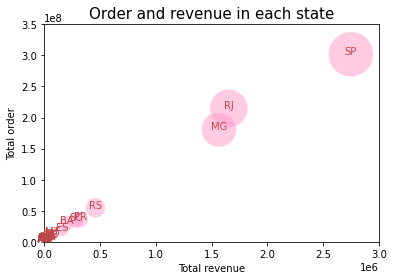

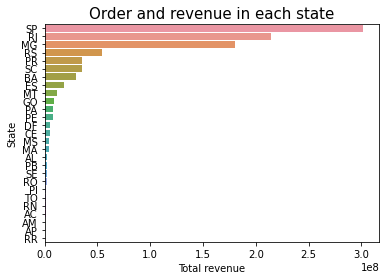

,geolocation_state,order_count,order_rev,tot_order,tot_rev,pct_order,pct_order_1
0,SP,2748072,3.019302e+08,7891228,9.437950e+08,0.35,31.99
1,RJ,1653349,2.147593e+08,7891228,9.437950e+08,0.21,22.75
2,MG,1566098,1.805842e+08,7891228,9.437950e+08,0.20,19.13
3,RS,459285,5.481530e+07,7891228,9.437950e+08,0.06,5.81
4,PR,322318,3.580083e+07,7891228,9.437950e+08,0.04,3.79


In [9]:
############################################ SQL code ##################################################
sql = """
WITH all_table AS    
    (SELECT * 
    FROM `nod-sql-copy.olist.orders` AS o
    JOIN `nod-sql-copy.olist.customers` AS c 
		ON o.customer_id = c.customer_id
    LEFT JOIN `nod-sql-copy.olist.order_items` USING(order_id)
    LEFT JOIN `nod-sql-copy.olist.geolocation` AS g 
		ON c.customer_zip_code_prefix = g.geolocation_zip_code_prefix
    ),
    
    table2 AS
    (SELECT geolocation_state, 
       
        COUNT(*) AS order_count,
        
        SUM(price) AS order_rev,
        
        SUM(COUNT(*))OVER() AS tot_order,
        SUM(SUM(price))OVER() AS tot_rev
        

      FROM all_table
      WHERE geolocation_state IS NOT null AND EXTRACT(YEAR FROM order_purchase_timestamp) = 2017
      GROUP BY geolocation_state
      ORDER BY 3 DESC)
      
SELECT *,
    ROUND(order_count/tot_order, 2) AS pct_order,
    ROUND(order_rev/tot_rev*100,2) AS pct_order
FROM table2
"""

df = pandas_gbq.read_gbq(sql)

############################################ VIsualization ##################################################

# use the scatterplot function to build the bubble map
#fig, ax = plt.subplots(1,2,figsize=(8, 14), frameon=False, dpi=100)
ax[0] = sns.scatterplot(data=df, x="order_count", y="order_rev", size="pct_order_1", legend=False, sizes=(20, 2000), alpha=0.5, color ='#ff99c8')
plt.xlim(0,3000000)
plt.ylim(0,350000000)


for line in range(0,df.shape[0]):
     ax[0].text(df.order_count[line], df.order_rev[line], df.geolocation_state[line], 
             horizontalalignment='center', size='medium', color='#bc4749')
ax[0].set_title('Order and revenue in each state', fontsize = 15)
ax[0].set_xlabel('Total revenue')
ax[0].set_ylabel('Total order')
plt.show()


ax[1] = sns.barplot(data = df, x = 'order_rev', y = 'geolocation_state')
ax[1].set_title('Order and revenue in each state', fontsize = 15)
ax[1].set_xlabel('Total revenue')
ax[1].set_ylabel('State')
plt.show()

############################################ SQL table ##################################################


df.head()

### Monthly order per state <a id='Monthly_order_per_state'></a>

Downloading: 100%|██████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 295.55rows/s]


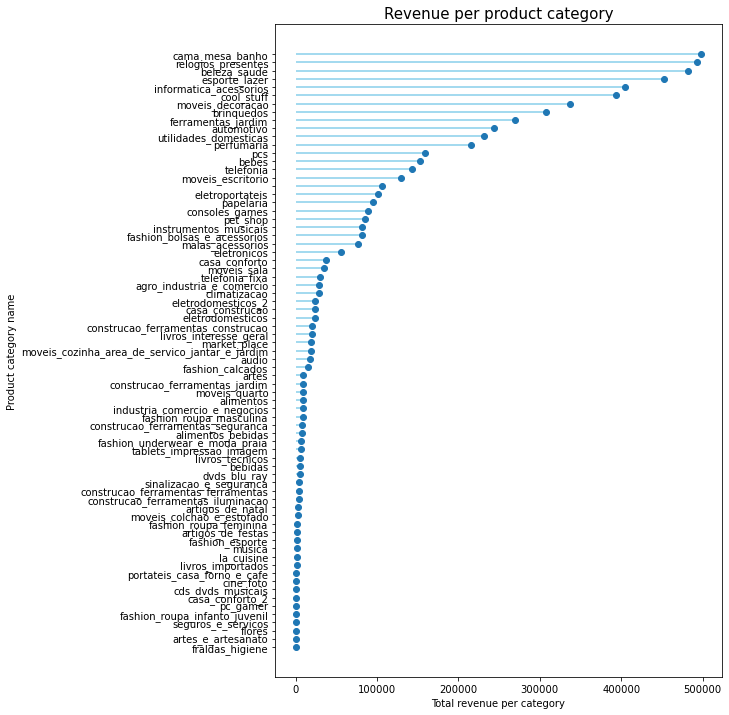

,product_category_name,total_order,pct_order,total_revenue,pct_revenue
0,cama_mesa_banho,5223,0.10,498440.0,0.08
1,relogios_presentes,2283,0.04,492795.0,0.08
2,beleza_saude,3668,0.07,481756.0,0.08
3,esporte_lazer,4095,0.08,452149.0,0.07
4,informatica_acessorios,3098,0.06,405079.0,0.07
...,...,...,...,...,...
68,fashion_roupa_infanto_juvenil,5,0.00,400.0,0.00
69,seguros_e_servicos,2,0.00,283.0,0.00
70,flores,8,0.00,271.0,0.00
71,artes_e_artesanato,2,0.00,152.0,0.00


In [48]:
##################################################SQL code#######################################################
sql = """
WITH table AS
    (SELECT *
    FROM `nod-sql-copy.olist.order_items`
    LEFT JOIN `nod-sql-copy.olist.orders` USING(order_id)
    LEFT JOIN `nod-sql-copy.olist.products` USING(product_id)
    )


SELECT product_category_name, 
      COUNT(*) AS total_order,
      ROUND(COUNT(*)/(SELECT COUNT(*) FROM table WHERE EXTRACT(YEAR FROM order_purchase_timestamp) = 2017 ), 2) AS pct_order,
      ROUND(SUM(price)) AS total_revenue,
      ROUND(SUM(price)/(SELECT SUM(price) FROM table WHERE EXTRACT(YEAR FROM order_purchase_timestamp) = 2017 ), 2) AS pct_revenue

FROM table
WHERE EXTRACT(YEAR FROM order_purchase_timestamp) = 2017 
GROUP BY product_category_name
ORDER BY 4 DESC;"""
df = pandas_gbq.read_gbq(sql)

################################################## VIsualization#######################################################
# Reorder it following the values:
ordered_df = df.sort_values(by='total_revenue')
my_range=range(1,len(df.index)+1)

# Make the plot
plt.figure(figsize = (8,12))
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['total_revenue'], color='skyblue')
plt.plot(ordered_df['total_revenue'], my_range, "o")

# Add titles and axis names
plt.yticks(my_range, ordered_df['product_category_name'])
plt.title("Revenue per product category", fontsize = 15)
plt.xlabel('Total revenue per category')
plt.ylabel('Product category name')

plt.show()

##################################################SQL TABLE#######################################################
df

### Majority payment method in 2017 <a id='Majority_payment_method_in_2017'></a>

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.31rows/s]


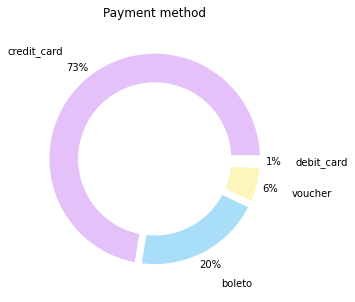

Credit card is the main method of payment


,payment_type,revenue_per_payment,pct_rev,count_of_payment,pct_order
0,credit_card,4942592.0,0.35,39239,0.33
1,boleto,1165208.0,0.08,11054,0.09
2,voucher,340490.0,0.02,3344,0.03
3,debit_card,35604.0,0.00,468,0.00


In [131]:
################################################## SQL #######################################################
sql = """
WITH table AS (SELECT *
            FROM `nod-sql-copy.olist.orders` AS o
              LEFT JOIN `nod-sql-copy.olist.order_payments` AS p USING(order_id)
              LEFT JOIN `nod-sql-copy.olist.order_items` AS oi USING(order_id)
          )

SELECT payment_type, 
      ROUND(SUM(price)) AS revenue_per_payment, 
      ROUND(SUM(price) / (SELECT SUM(price) FROM table), 2) AS pct_rev,
      COUNT(*) AS count_of_payment,
      ROUND(COUNT(*) /(SELECT COUNT(*) FROM table), 2) AS pct_order
FROM table
WHERE EXTRACT(YEAR FROM order_purchase_timestamp) = 2017 
GROUP BY payment_type
ORDER BY 2 DESC;

-- it is credit card the most and make the most revenue"""
df = pandas_gbq.read_gbq(sql)

################################################## visualization#######################################################

plt.figure(figsize = (5,5))

# create data
size_of_groups= df.count_of_payment
names = df.payment_type

# Create a pieplot
plt.pie(size_of_groups)

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')

# Give color names
plt.pie(size_of_groups, labels=names, colors=['#e4c1f9','#a9def9','#fcf6bd','#ff99c8'],
       autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.3,
       wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Payment method')

# Show the graph
plt.show()

################################################## comment #######################################################
print('Credit card is the main method of payment')

##################################################SQL TABLE#######################################################
df

### Most popular product category <a id='Most_popular_product_category '></a>

Downloading: 100%|███████████████████████████████████████████████████████████████| 318/318 [00:00<00:00, 1257.37rows/s]


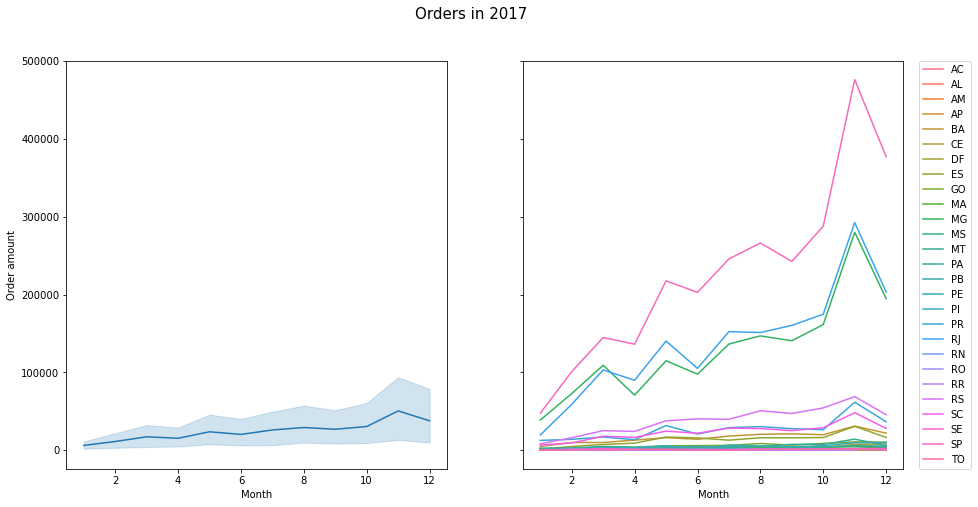

,geolocation_state,month_2017,order_count,pct_order_2017,order_rev,pct_rev_2017
0,AC,1,89,0.02,13061.10,0.01
1,AC,2,277,0.05,29366.30,0.03
2,AC,3,329,0.06,74872.26,0.08
3,AC,4,363,0.07,65539.64,0.07
4,AC,5,890,0.17,263609.96,0.29
...,...,...,...,...,...,...
313,TO,8,884,0.09,169160.65,0.10
314,TO,9,1554,0.16,196445.95,0.12
315,TO,10,1186,0.12,244127.89,0.15
316,TO,11,1743,0.18,232187.56,0.14


In [38]:
############################################ SQL code ##################################################
sql = """
WITH all_table AS    
    (SELECT * 
    FROM `nod-sql-copy.olist.orders` AS o
    JOIN `nod-sql-copy.olist.customers` AS c 
		ON o.customer_id = c.customer_id
    LEFT JOIN `nod-sql-copy.olist.order_items` USING(order_id)
    LEFT JOIN `nod-sql-copy.olist.geolocation` AS g 
		ON c.customer_zip_code_prefix = g.geolocation_zip_code_prefix
    ),
 monthly_report AS
      (SELECT geolocation_state, 
        DATE_TRUNC(order_purchase_timestamp, MONTH) AS oreder_month,
        COUNT(*) AS order_count,
        SUM(COUNT(*)) OVER(PARTITION BY geolocation_state) AS tot_order_2017,
        SUM(price) AS order_rev,
        SUM(SUM(price))OVER(PARTITION BY geolocation_state)  AS tot_rev_2017

      FROM all_table
      WHERE geolocation_state IS NOT null AND EXTRACT(YEAR FROM order_purchase_timestamp) = 2017
      GROUP BY geolocation_state, 2
      ORDER BY 1,2)

SELECT geolocation_state,
      EXTRACT(MONTH FROM oreder_month) AS month_2017,
       order_count, 
       ROUND(order_count/tot_order_2017, 2) AS pct_order_2017,
       order_rev,
       ROUND(order_rev/tot_rev_2017,2) AS pct_rev_2017
FROM  monthly_report

"""

df = pandas_gbq.read_gbq(sql)

############################################ Visualization ##################################################

fig, ax = plt.subplots(1,2, figsize = (15,7.5), sharey=True)

sns.lineplot(data = df, x = 'month_2017', y = 'order_count', ax = ax[0] )
sns.lineplot(data = df, x = 'month_2017', y = 'order_count', hue = 'geolocation_state', ax = ax[1])

ax[1].legend(loc= (1.04,0))
fig.suptitle('Orders in 2017', fontsize=15)

ax[0].set_xlabel('Month')
ax[1].set_xlabel('Month')
ax[0].set_ylabel('Order amount')

plt.show()

############################################ SQL table ##################################################
df